### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

### Переходим к практике

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
# Для построение тематичесмких векторов используем библиотеку (словарик)
from gensim.corpora.dictionary import Dictionary

In [5]:
# Предобработка текста
# Библиотека регулярных выражений
import re
import numpy as np
# библиотека стопслова (предлогии и бесмысленные слова)
from nltk.corpus import stopwords
# метод который будет токенизировать наш текст (разбивка текста на слова)
from razdel import tokenize
# библиотека приводит каждое слово в нормальное слово так как слово может по разному склоняться
import pymorphy2

In [6]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [7]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [8]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [9]:
%%time
#Запускаем очистку текста.
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/tmp/ipykernel_7998/2296537027.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 25 s, sys: 537 ms, total: 25.5 s
Wall time: 25.5 s


In [10]:
%%time
#Запускаем лемматизацию текста.
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 2min 54s, sys: 88.6 ms, total: 2min 54s
Wall time: 2min 54s


А теперь в 3 строчки обучим нашу модель

In [11]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
# матрица
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [14]:
#common_dictionary[10]

Все просто - это словарь наших слов

Запускаем обучение

In [13]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 53.9 s, sys: 1.58 s, total: 55.5 s
Wall time: 27.7 s


In [15]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [16]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(1, 0.26474696),
 (2, 0.02572074),
 (5, 0.6197674),
 (7, 0.038299114),
 (14, 0.03009236)]

In [17]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: млрд рубль источник данные министерство журнал сотрудник
topic_1: игра кг золото nn вес аналог ндс
topic_2: исследование египет лаборатория восток агентство женщина иран
topic_3: налог инвестиция расчёт тыс террорист боевик япония
topic_4: фонд километр станция бомба орден образовать отдых
topic_5: первый рост всё большой жизнь цена хороший
topic_6: сша военный американский nn фонд россия российский
topic_7: ракета экипаж фильм иск ступень мышь обнаружить
topic_8: газ россия nn путин поток медведев продукция
topic_9: млн вирус доход составить сумма тыс россиянин
topic_10: москва центр поверхность пенсия площадь русский день
topic_11: дом статья белый школа вицепремьер студент производить
topic_12: подросток водитель зуб сближение химия прибытие перо
topic_13: сенатор дональд шотландский атаман гарантия фанни хьюстон
topic_14: ребёнок гражданин мозг россия пострадать взрыв закон
topic_15: смерть северный университет болезнь южный умереть корея
topic_16: журнал завод век следств

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [18]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [19]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.120959,0.000000,0.0,0.0,0.000000,0.515705,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.23374,0.103203,0.0,0.0,0.0,0.0
1,4896,0.0,0.277939,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
2,4897,0.0,0.264739,0.025729,0.0,0.0,0.619862,0.000000,0.038299,0.0,...,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
3,4898,0.0,0.080135,0.000000,0.0,0.0,0.881958,0.026597,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
4,4899,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.230401,0.000000,0.0,...,0.0,0.0,0.064614,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [20]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [21]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [22]:
doc_dict[293622]

array([0.        , 0.02898445, 0.06238026, 0.02719242, 0.        ,
       0.24203689, 0.        , 0.12258618, 0.15522209, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0957002 ,
       0.        , 0.07766961, 0.11851618, 0.        , 0.03472973,
       0.        , 0.        , 0.02547362, 0.        , 0.        ])

In [23]:
#user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, method='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if method == 'mean':
        user_vector = np.mean(user_vector, 0)
    elif method == 'median':
        user_vector = np.median(user_vector, 0)
    elif method == 'max':
        user_vector = np.max(user_vector, 0)
    return user_vector

In [25]:
#get_user_embedding(user_articles_list)

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [26]:
#users['articles'].iloc[33]

In [27]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

In [102]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [126]:
def make_model_predict(method):
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, method=method), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    
    target = pd.read_csv("users_churn.csv")
    #target.head(3)
    
    X = pd.merge(user_embeddings, target, 'left')
    #X.head(3)
    
    #разделим данные на train/test
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                        X['churn'], random_state=0)
    
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    #наши прогнозы для тестовой выборки
    preds = logreg.predict_proba(X_test)[:, 1]
    #preds[:10]
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    idx = np.argmax(fscore)
    
    #мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
    font = {'size' : 12}
    plt.rc('font', **font)
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[idx])
    plt.figure(figsize=(6, 4))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title=f'Confusion matrix, {method}')
    #plt.savefig("conf_matrix.png")
    plt.show()
    
    return method, thresholds[idx], fscore[idx], precision[idx], recall[idx], roc_auc_score(y_test, preds)   

### Рассчитаем Precision, Recall, F_score

Confusion matrix, without normalization
[[1657   98]
 [  53  192]]


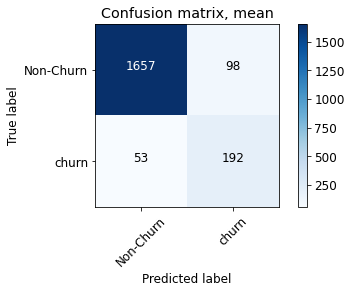

Confusion matrix, without normalization
[[1672   83]
 [  38  207]]


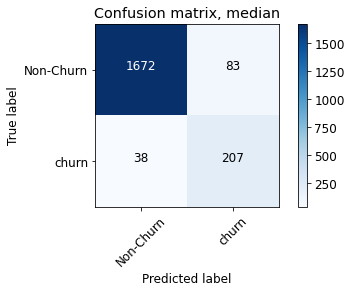

Confusion matrix, without normalization
[[1711   44]
 [  46  199]]


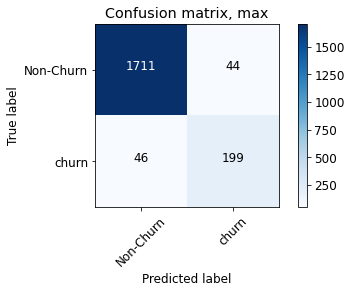

In [127]:
df = pd.DataFrame([
    make_model_predict(method='mean'),
    make_model_predict(method='median'),
    make_model_predict(method='max')
],
columns=['method', 'Threshold', 'FScore', 'Precision', 'Recall', 'roc_auc_score'])

In [128]:
df

,method,Threshold,FScore,Precision,Recall,roc_auc_score
0,mean,0.257052,0.720149,0.663230,0.787755,0.954537
1,median,0.274792,0.776119,0.714777,0.848980,0.971466
2,max,0.364064,0.817996,0.819672,0.816327,0.973457
